In [1]:
import glob
import numpy as np
import scipy.io
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt
from parula import parula_map

In [2]:
def expd(original_mat, expd_size, sample_ratio):
    ori_sz = original_mat.shape[0]
    if (ori_sz<expd_size) :
        sz_diff = np.floor((expd_size-original_mat.shape[0])/2).astype(int)
        output = np.zeros([expd_size,expd_size])
        output[sz_diff:sz_diff+original_mat.shape[0], sz_diff:sz_diff+original_mat.shape[1]] = original_mat
    else:
        output = original_mat[int(np.floor(ori_sz/2)-np.floor(expd_size/2)):int(np.floor(ori_sz/2)+np.floor(expd_size/2)),
                            int(np.floor(ori_sz/2)-np.floor(expd_size/2)):int(np.floor(ori_sz/2)+np.floor(expd_size/2))]
    return output[::sample_ratio,::sample_ratio]

def loadMat(filePath, expd_size, matlab_var,sample_ratio):
    tmp = scipy.io.loadmat(filePath)[matlab_var]
    try:
        tmp = tmp.todense()
    except:
        pass

    tmp = expd(tmp, expd_size, sample_ratio)
    tmp = np.expand_dims(tmp,axis=0)
    tmp = np.expand_dims(tmp,axis=0)
    tmp = np.expand_dims(tmp,axis=4)
    return tmp

In [3]:
save_file_1 = '../dataset_for_ML/NG_all_case_time_structured_oldModel_02262023.hdf5'
save_file_2 = '../dataset_for_ML/NG_all_CNN_restructured_oldModel_02262023.hdf5'

# get all cases folder name
cases = glob.glob('D:\\NeuronGrowthML\\Matlab_simulation_data_oldModel\\case*')
cases.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

expd_sz = 600
sample_ratio = 2
numExtract = 60

dm_sz = int(expd_sz/sample_ratio)
numCases = int(len(cases))
hdf5_file = h5py.File(save_file_1, mode='w')
hdf5_file.create_dataset("NG_data", (numCases,numExtract,dm_sz,dm_sz,3), np.float32, chunks=(1,1,dm_sz,dm_sz,3), compression="gzip")

for i in tqdm(range(numCases), desc=f'Running ...'):
    case = cases[i].replace('D:\\NeuronGrowthML\\Matlab_simulation_data_oldModel\\case','')
    
    # defined input data folder and grab a list of data files
    phiPath = glob.glob(cases[i]+'\\phi_*00.mat')
    phiPath.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    
    # phi_final = loadMat(phiPath[-1], expd_sz, 'phi_plot', 1)
    # plt.figure(figsize=(12, 12), dpi=400)
    # plt.imshow(phi_final[0,0,:,:,0],cmap = parula_map)
    # plt.colorbar()
    # plt.savefig(f'D:\\NeuronGrowthML\\Matlab_simulation_data_neuriteFeatures\\all_results\\phi_final_{i}.png')
    # plt.close()

    # calculate iterations to be extracted
    end_iter = phiPath[-1].replace(cases[i]+'\\phi_','')
    end_iter = int(end_iter.replace('.mat',''))
    iter_incre = int(np.floor((end_iter/numExtract)/100)*100)
    
    # load theta
    thetaPath = glob.glob(cases[i]+'\\theta_'+str(end_iter)+'.mat')
    theta = loadMat(thetaPath[-1], expd_sz, 'theta_plot',sample_ratio)

    iters = 1700
    # plt.figure(figsize=(15, 8), dpi=80)
    for j in range(numExtract):        
        # load phi
        phi_path = 'D:\\NeuronGrowthML\\Matlab_simulation_data_oldModel\\case'+str(case)+'\\phi_'+str(iters)+'.mat'
        phi_dwn = np.round(loadMat(phi_path, expd_sz, 'phi_plot', sample_ratio))

        if np.max(phi_dwn)==0:
            print(f'!!{phiPath[j]}')

        # iter_mat = np.expand_dims(np.expand_dims(np.expand_dims((iters/end_iter)*np.ones([dm_sz,dm_sz]),axis=0),axis=0),axis=4)
        iter_mat = np.expand_dims(np.expand_dims(np.expand_dims((j/numExtract)*np.ones([dm_sz,dm_sz]),axis=0),axis=0),axis=4)
        iter_vars = np.concatenate([phi_dwn,theta,iter_mat],axis=4)
        hdf5_file["NG_data"][i,j,...] = iter_vars

        iters = int((j+1)*iter_incre)

        # plt.subplot(1,3,1)
        # plt.imshow(phi_dwn[0,0,:,:,0],cmap = parula_map)
        # plt.title(f'Case {case} | Iter {iters}')
        # plt.colorbar()
        # plt.subplot(1,3,2)
        # plt.imshow(theta[0,0,:,:,0],cmap = parula_map)
        # plt.title(f'Case {case} | Iter {iters}')
        # plt.colorbar()
        # plt.subplot(1,3,3)
        # plt.imshow(iter_mat[0,0,:,:,0],cmap = parula_map)
        # plt.title(f'Case {case} | Iter {iters}')
        # plt.colorbar()

    # plt.colorbar
    # plt.show()

hdf5_file.close()

Running ...: 100%|██████████| 105/105 [02:36<00:00,  1.49s/it]


(105, 60, 300, 300, 3)
Random ID: 37 | Random IDX 30


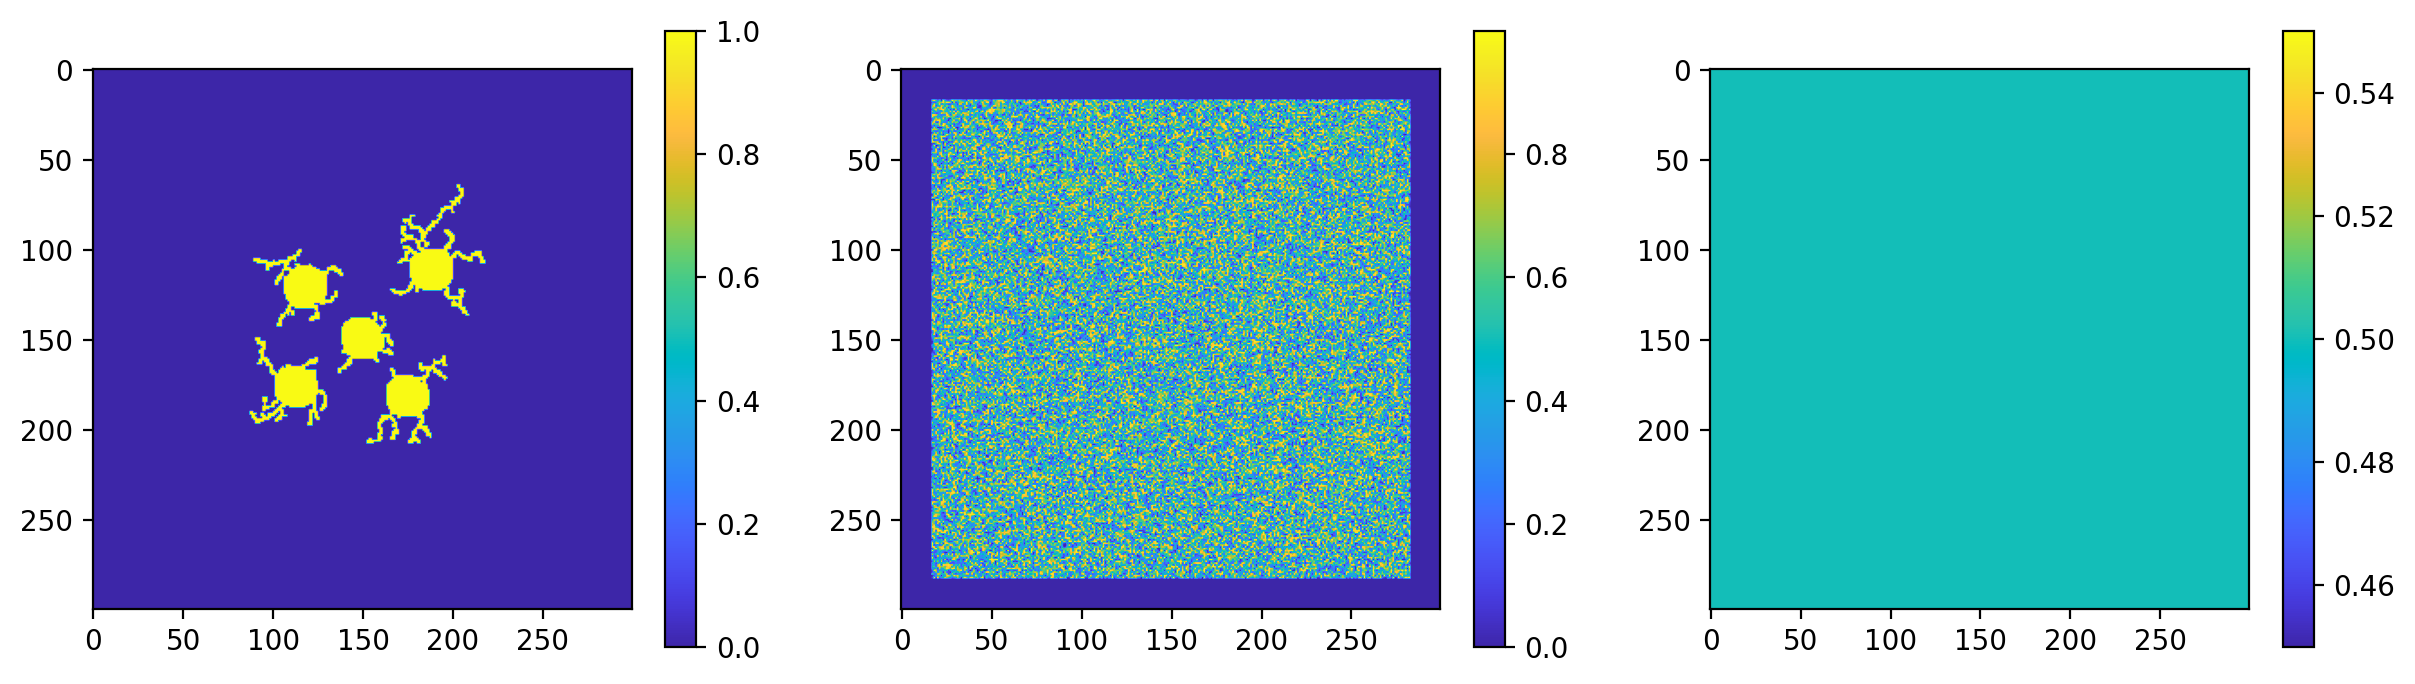

In [4]:
h5 = h5py.File(save_file_1, mode='r')
data = h5.get('NG_data')
print(data.shape)

id = np.random.randint(data.shape[0])
idx = np.random.randint(data.shape[1])
print(f'Random ID: {id} | Random IDX {idx}')
plt.figure(figsize=(20, 4), dpi=200)
plt.subplot(1,4,1)
plt.imshow(data[id,idx,:,:,0],cmap = parula_map)
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(data[id,idx,:,:,1],cmap = parula_map)
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(data[id,idx,:,:,2],cmap = parula_map)
plt.colorbar()
# plt.subplot(1,4,4)
# plt.imshow(data[id,idx,:,:,3],cmap = parula_map)
# plt.colorbar()
plt.show()

In [5]:
# h5 = h5py.File(save_file_1, mode='r')
# data = h5.get('NG_data')
# print(data.shape)

# # for i in tqdm(range(data.shape[0]), desc="Checking ..." ):
# #     if np.max(data[i,0,:,:])==0:
# #         raise Exception(f'!! Not clean !! ind: {i} !!')
# #     else:
# #         continue
    
# print('Check passed.')

sz = data.shape[0]*(data.shape[1])
hdf5_file = h5py.File(save_file_2, mode='w')
hdf5_file.create_dataset("input", (sz, 3, data.shape[2],data.shape[3]), np.float32, chunks=(1, 2, data.shape[2],data.shape[3]), compression="gzip")
hdf5_file.create_dataset("output", (sz, 1, data.shape[2],data.shape[3]), np.float32, chunks=(1, 1, data.shape[2],data.shape[3]), compression="gzip")

k = 0
for i in tqdm(range(data.shape[0]), desc="Running ..."):
    for j in range(data.shape[1]):
        hdf5_file["input"][k,0,:,:] = data[i,0,:,:,0]
        hdf5_file["input"][k,1,:,:] = data[i,-1,:,:,1]
        hdf5_file["input"][k,2,:,:] = data[i,j,:,:,2]
        hdf5_file["output"][k,0,:,:] = data[i,j,:,:,0]
        k+=1  
hdf5_file.close()

Running ...: 100%|██████████| 105/105 [02:37<00:00,  1.50s/it]


Input data shape: (6300, 3, 300, 300) | Output data shape: (6300, 1, 300, 300)
Random ID: 3353


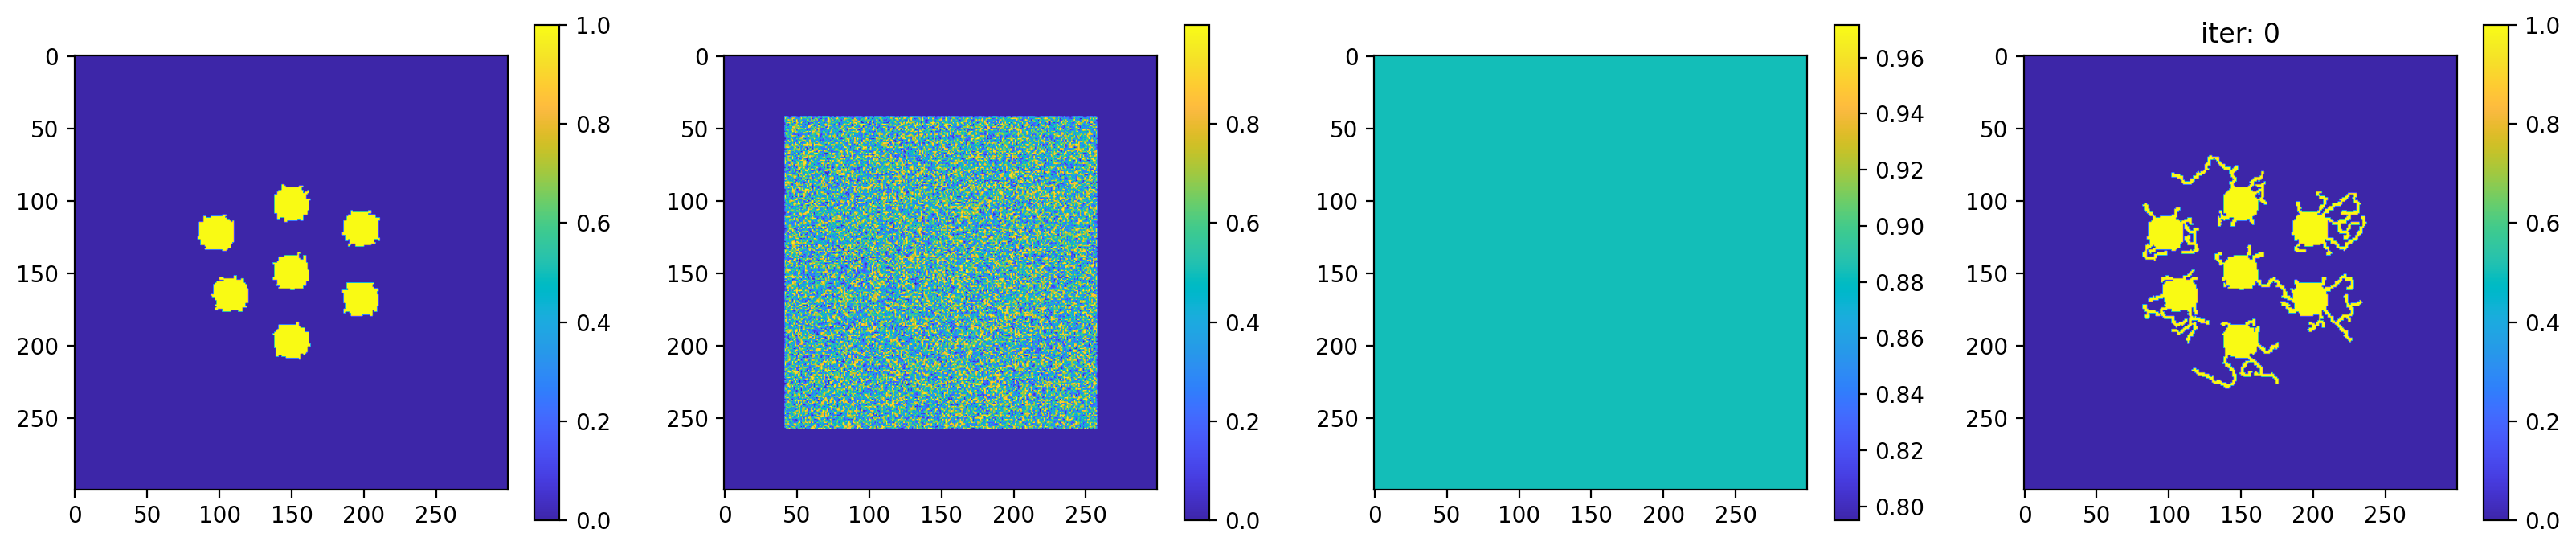

Random ID: 4326


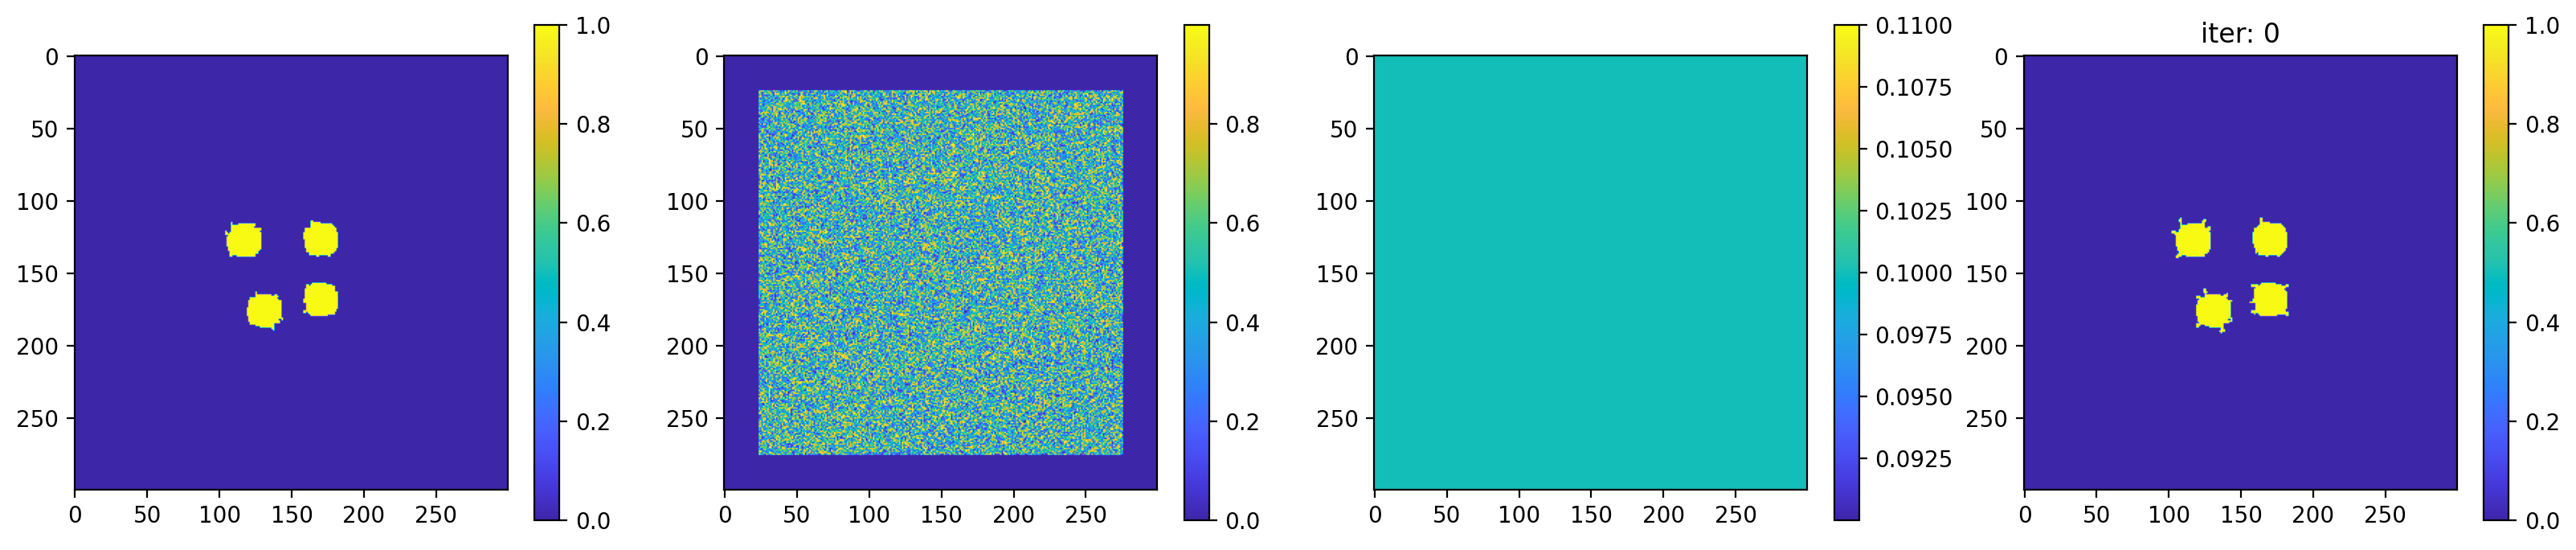

Random ID: 4189


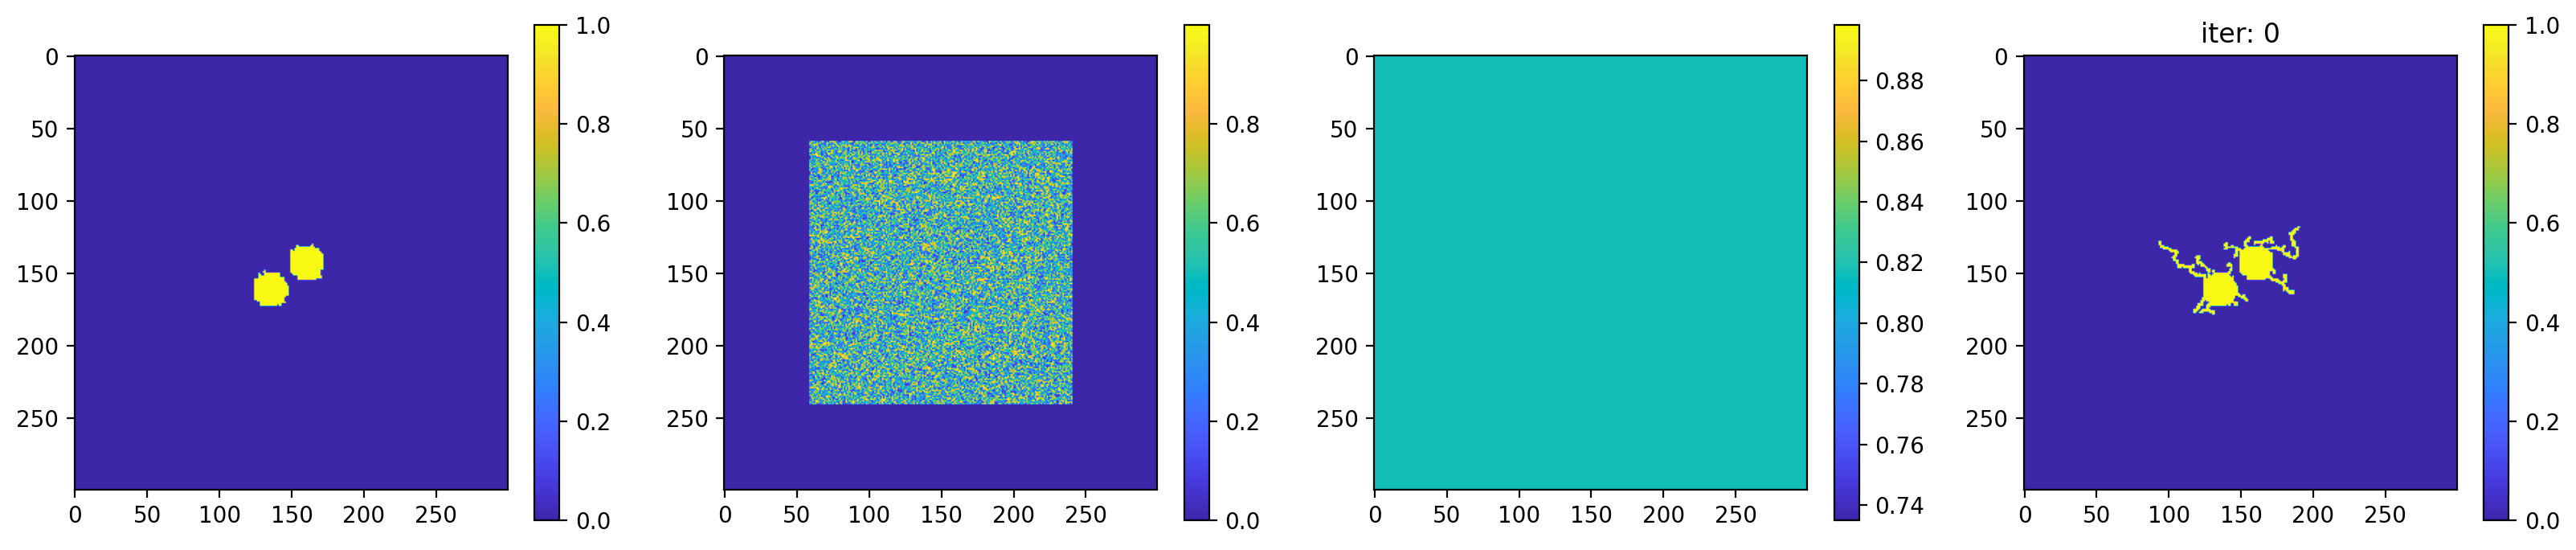

Random ID: 3202


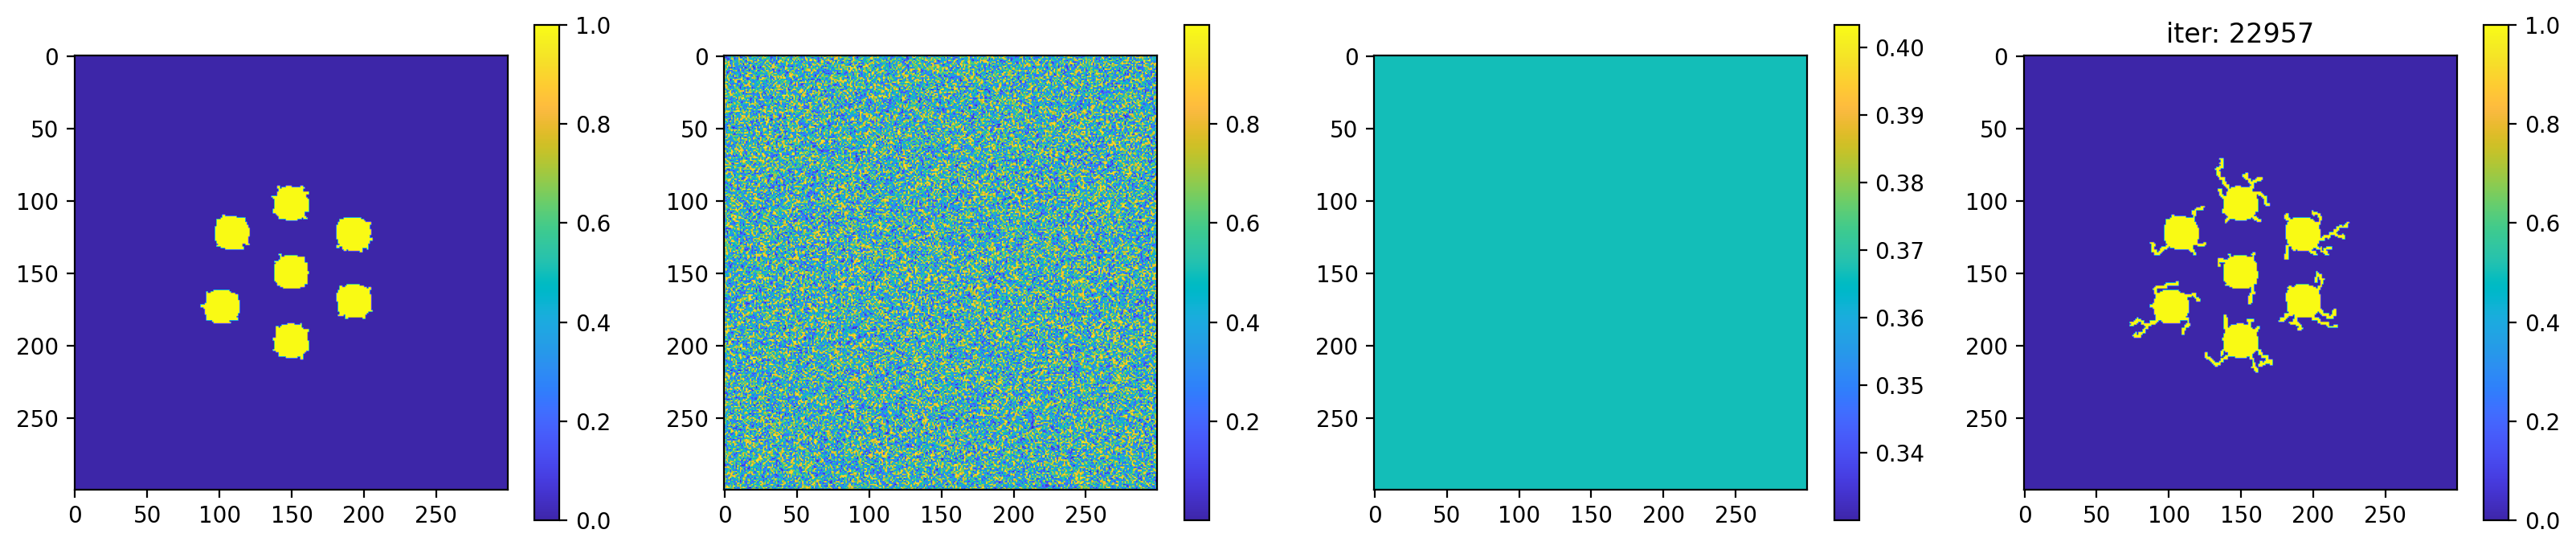

Random ID: 3764


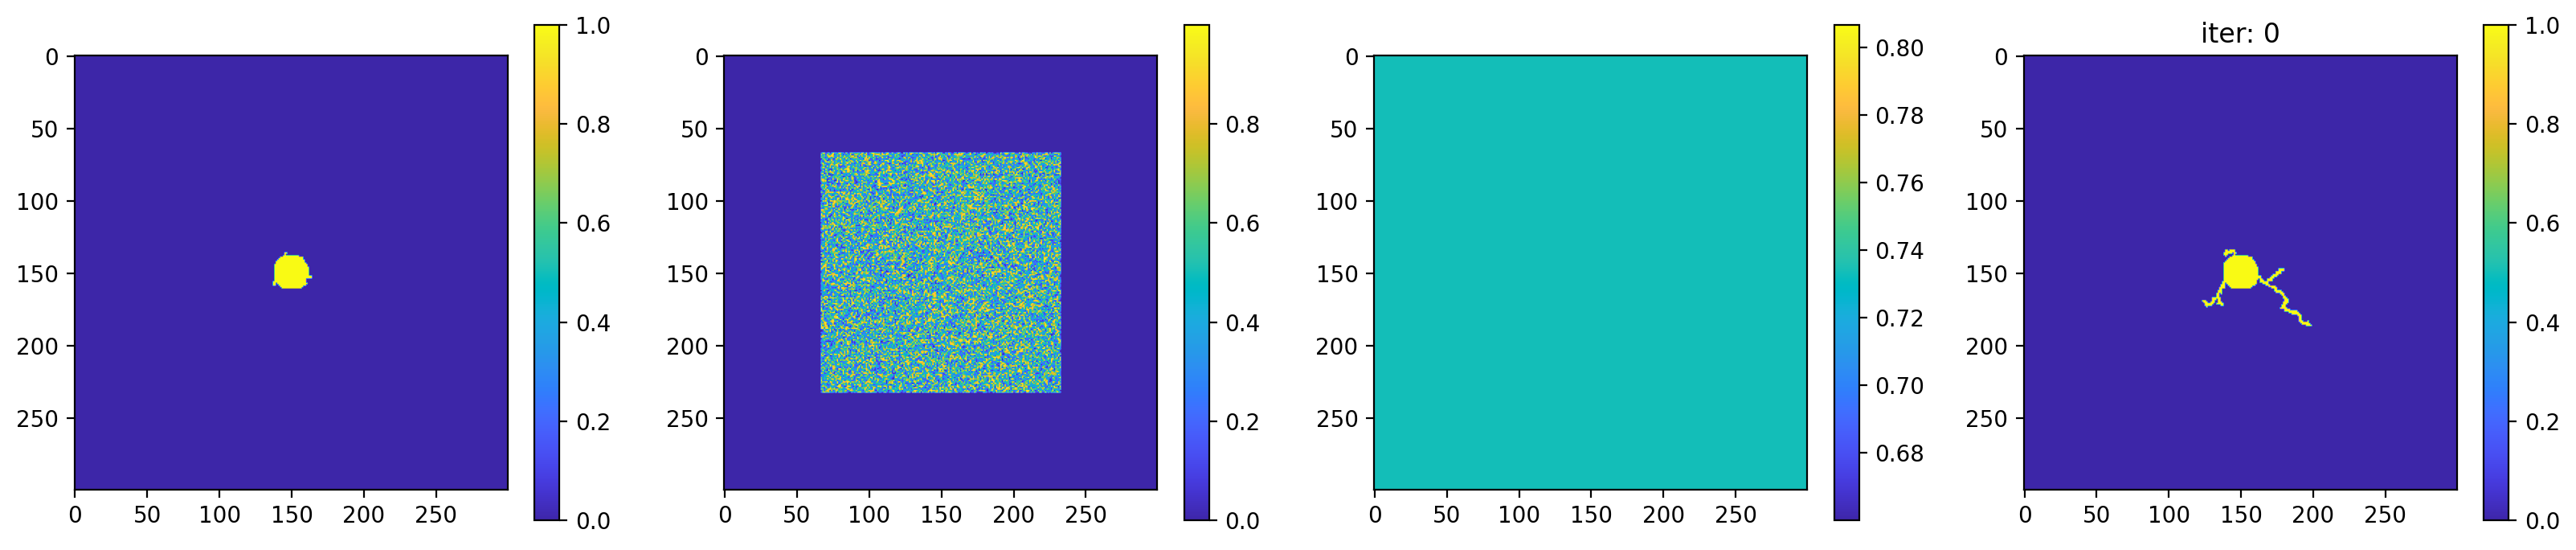

Random ID: 330


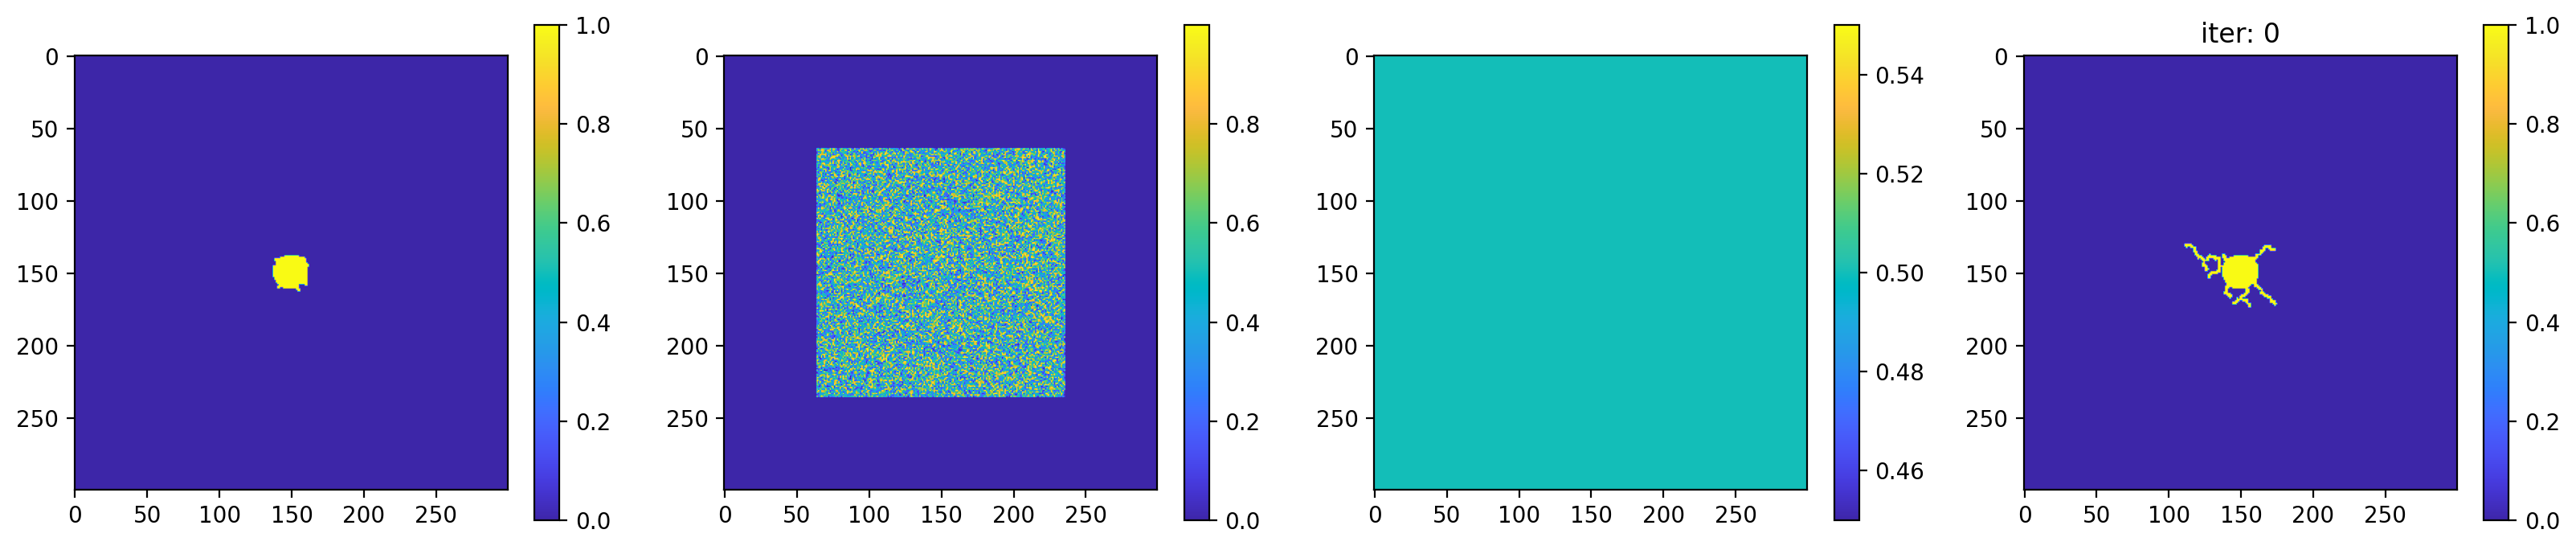

Random ID: 2425


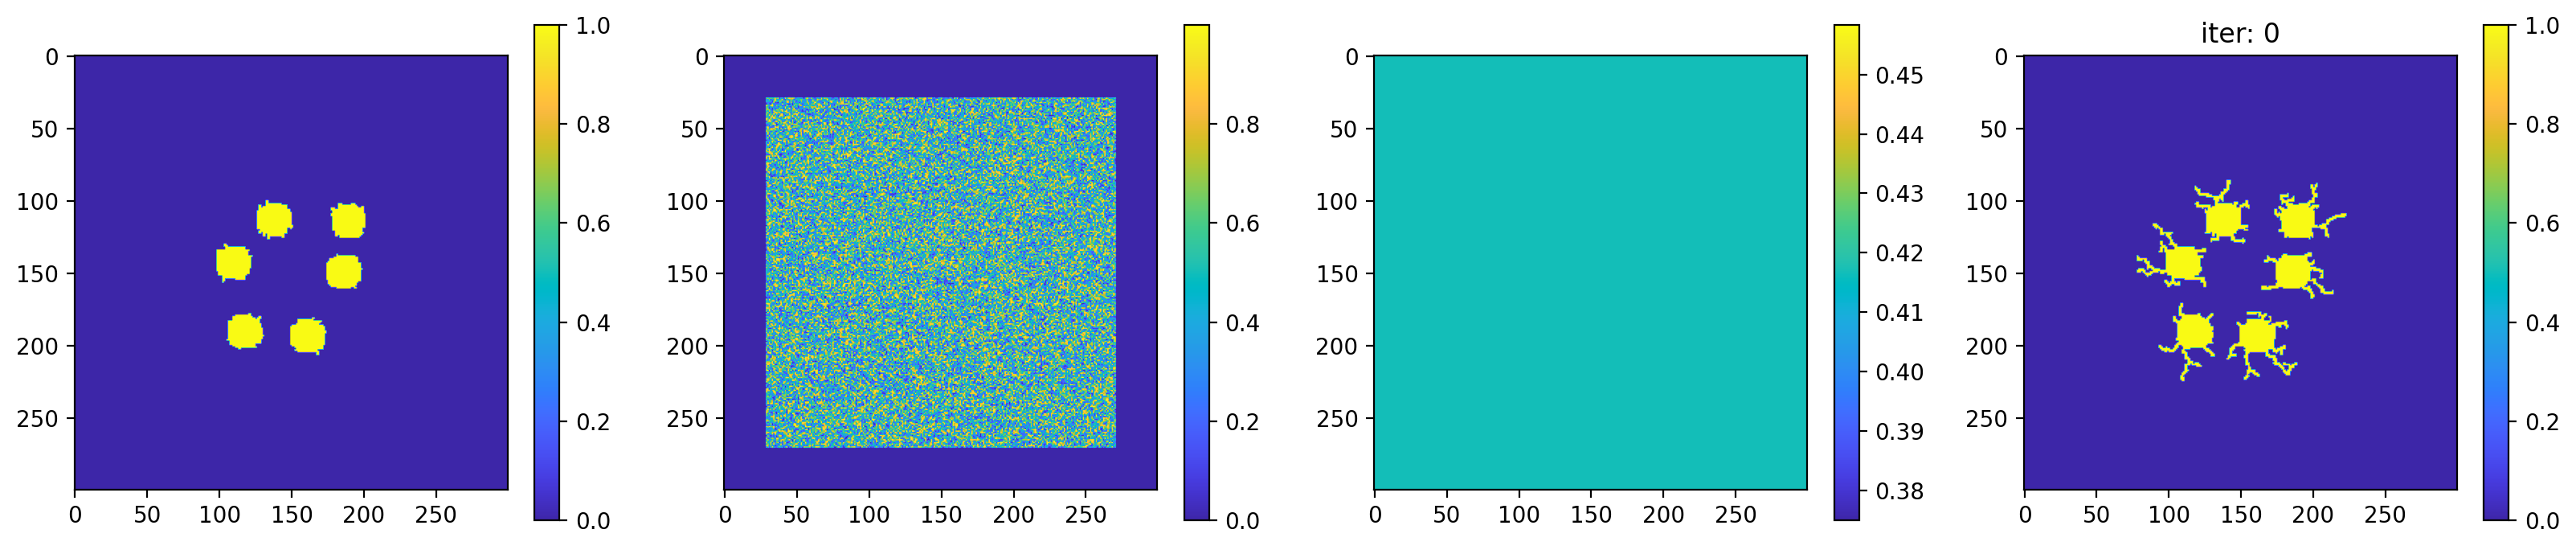

Random ID: 2775


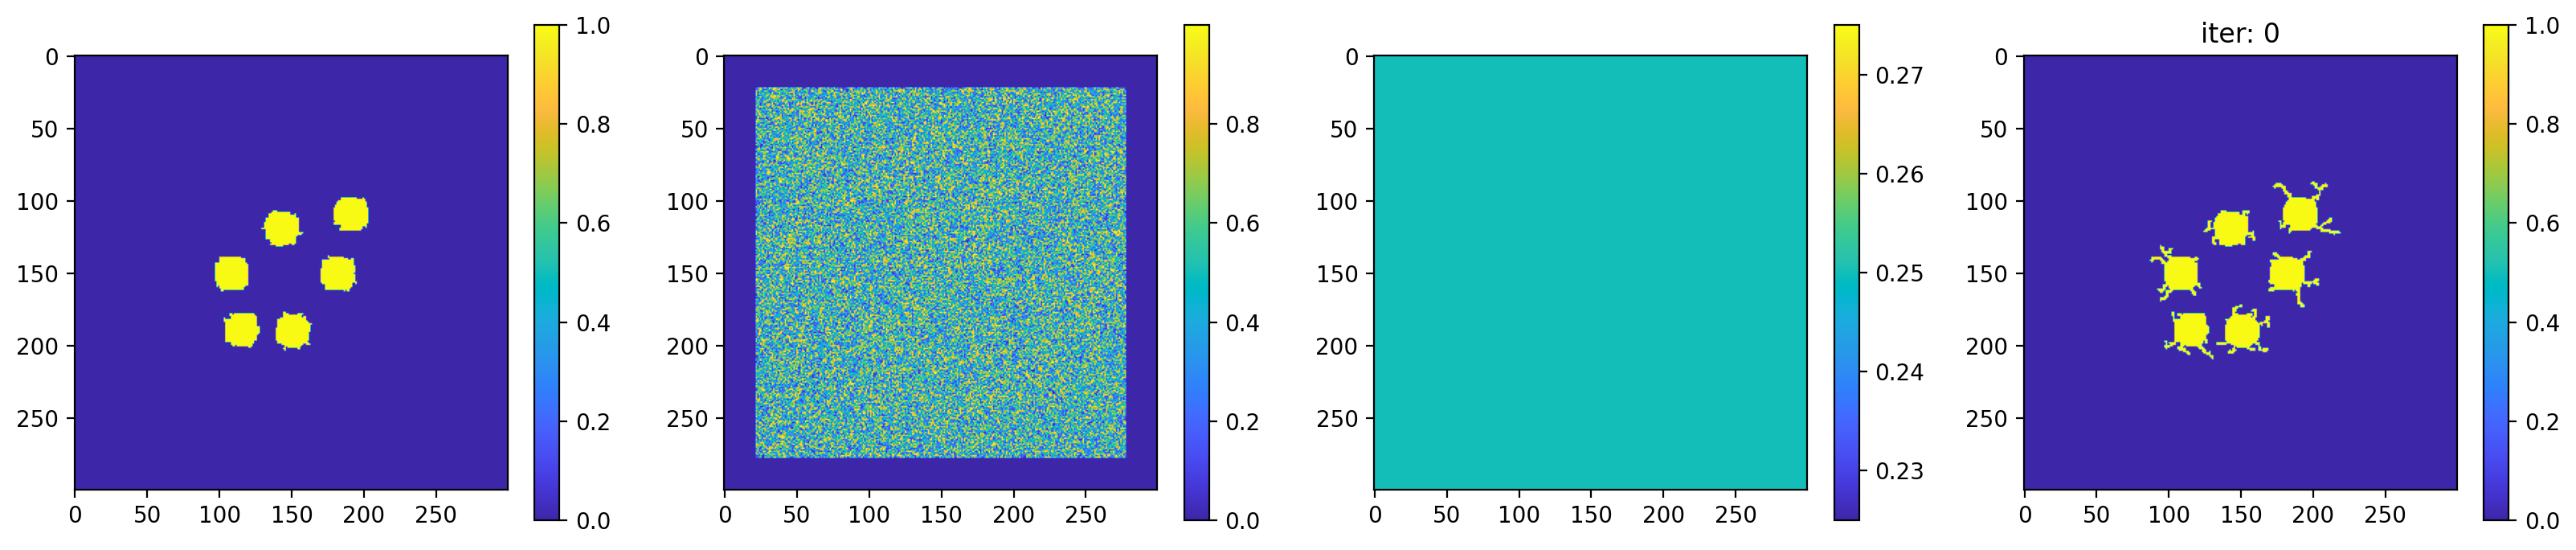

Random ID: 3964


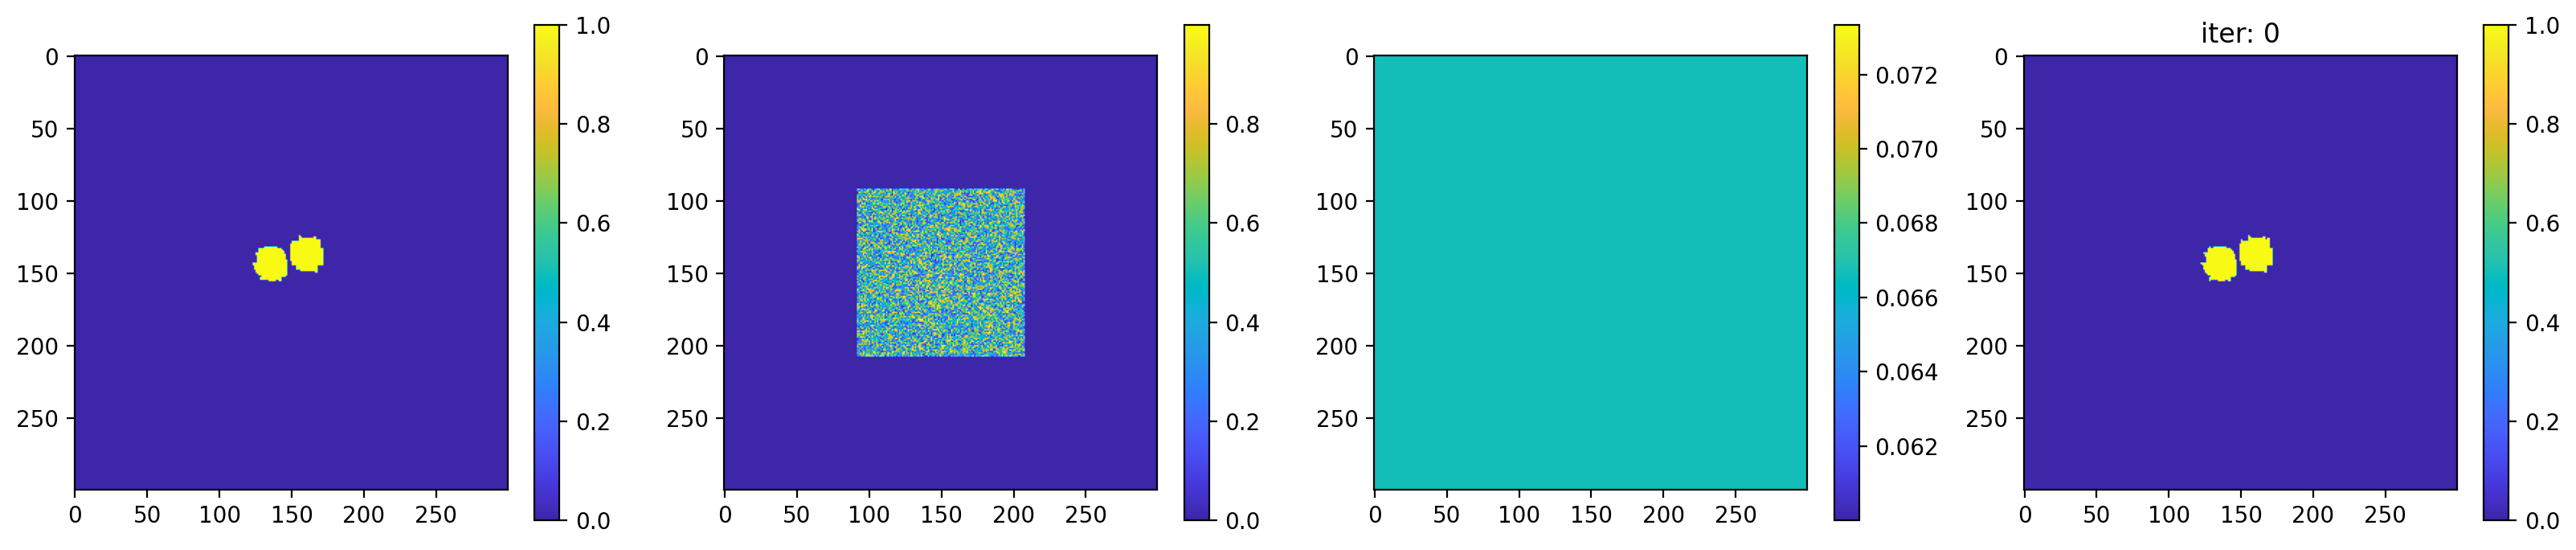

Random ID: 5918


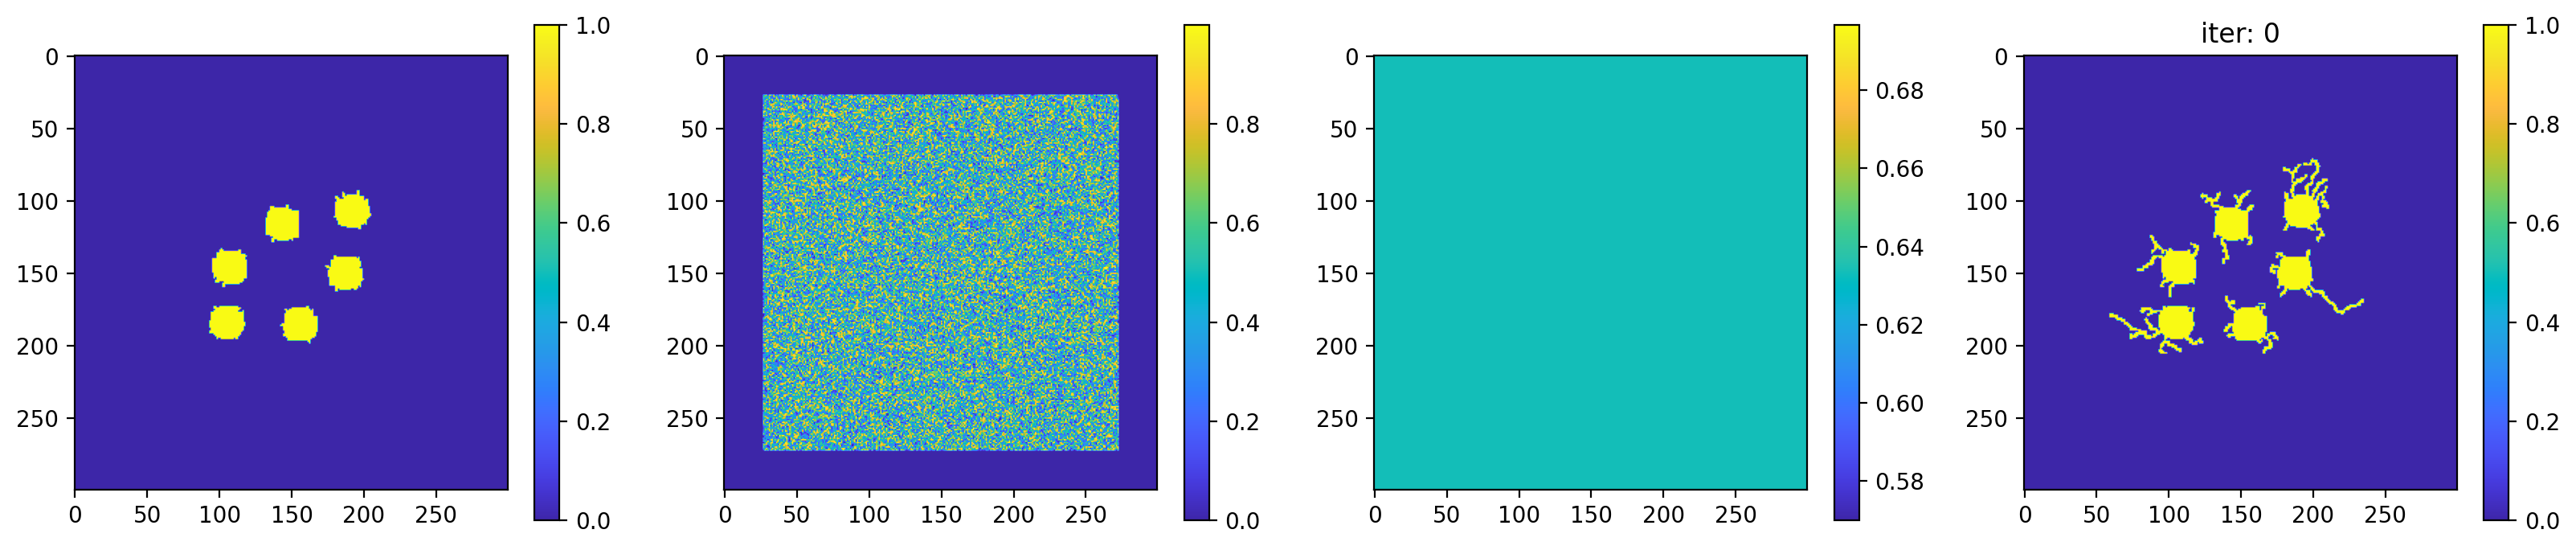

In [4]:
h5 = h5py.File(save_file_2, mode='r')
data_in = h5.get('input')
data_out = h5.get('output')
print(f'Input data shape: {data_in.shape} | Output data shape: {data_out.shape}')

for _ in range(10):
    id = np.random.randint(data_in.shape[0])
    print(f'Random ID: {id}')
    plt.figure(figsize=(20, 4), dpi=200)
    plt.subplot(1,4,1)
    plt.imshow(data_in[id,0,:,:],cmap = parula_map)
    plt.colorbar()
    plt.subplot(1,4,2)
    plt.imshow(data_in[id,1,:,:],cmap = parula_map)
    plt.colorbar()
    plt.subplot(1,4,3)
    plt.imshow(data_in[id,2,:,:],cmap = parula_map)
    plt.colorbar()
    plt.subplot(1,4,4)
    plt.imshow(data_out[id,0,:,:],cmap = parula_map)
    plt.title(f'iter: {int(data_in[id,1,0,0]*35000)}')
    plt.colorbar()
    plt.show()